In [1]:
cd ../marathon/

/home/ubuntu/boston-marathon/marathon


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import marathonlib

In [3]:
def plot_model_deviation(model, X_train, y_train, X_test, y_test, y_max = 0.04):
    print 'Train R^2:', model.score(X_train, y_train)
    print 'Test R^2:', model.score(X_test, y_test)
    y_predict = model.predict(X_test)
    print 'Standard Error of Test:', marathonlib.time_to_timestring(np.var(y_test-y_predict)**0.5)
    plt.hist(y_test-y_predict, bins=100, range=(-100,250), normed=True, linewidth=0)
    plt.xlim(-100, 250)
    plt.ylim(0, y_max)
    plt.vlines(0, 0, 1)

In [4]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [5]:
df = pd.read_csv('data/boston2015_priors+.csv')
df15 = pd.read_csv('data/boston2015_clean.csv')

In [6]:
print df.shape

(101850, 26)


In [8]:
df.columns

Index([u'marathon', u'year', u'bib', u'name', u'firstname', u'lastname',
       u'age', u'gender', u'city', u'state', u'country', u'citizenship',
       u'offltime', u'prior_marathon', u'prior_year', u'prior_time', u'elite',
       u'qualifier', u'home', u'avgtemp', u'avghumid', u'avgwind', u'avgwindE',
       u'avgwindN', u'isgusty', u'rainhours'],
      dtype='object')

In [9]:
df15.columns

Index([u'marathon', u'year', u'bib', u'url', u'name', u'firstname',
       u'lastname', u'age', u'gender', u'city', u'state', u'country',
       u'citizenship', u'subgroup', u'gunstart', u'starttime', u'time5k',
       u'time10k', u'time15k', u'time20k', u'timehalf', u'time25k', u'time30k',
       u'time35k', u'time40k', u'pace', u'projtime', u'offltime', u'nettime',
       u'overall_rank', u'gender_rank', u'division_rank', u'other1', u'other2',
       u'other3', u'other4'],
      dtype='object')

In [10]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_unique_runners(df, func=np.median):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        if len(runners > 1):
            runner['prior_year'] = func(runners['year'])
            runner['prior_marathon'] = ''
            runner['prior_time'] = func(runners['prior_time'])
        runners_list.append(runner)
    #unique_df = pd.concat(runners_list, axis=1).T
    unique_df = pd.DataFrame().append(runners_list)
    return unique_df

In [11]:
sum(df['prior_time'].isnull())

0

In [12]:
unique_df = get_unique_runners(df).copy()
print unique_df.shape

(22724, 26)


In [13]:
len(df['prior_marathon'].unique())

922

In [14]:
print '# of prior records:', len(df)
print '# of unique runners w/priors:', len(unique_df)
print '# of runners in 2015:', len(df15)
print '2015 Runners found: {:.1f}%'.format(len(unique_df) * 100. / len(df15))

# of prior records: 101850
# of unique runners w/priors: 22724
# of runners in 2015: 26403
2015 Runners found: 86.1%


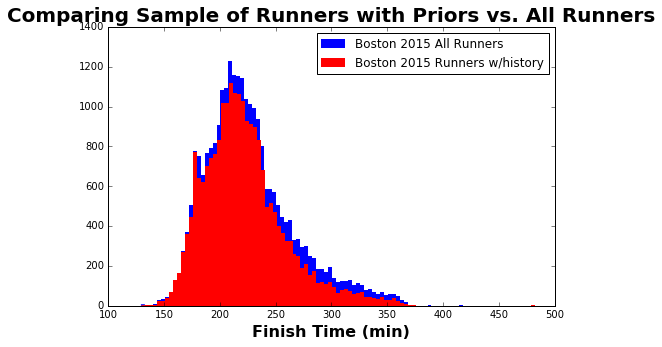

Boston 2015 w/priors: 221.729488136
Boston 2015: 226.339677309


In [15]:
# Finish times of Boston compared with priors
fig = plt.figure(figsize=(8, 5))
plt.hist(df15['offltime'], bins=100, label='Boston 2015 All Runners', linewidth=0, color='b')
plt.hist(unique_df['offltime'], bins=100, label='Boston 2015 Runners w/history', linewidth=0, color='r')
plt.legend()
plt.title('Comparing Sample of Runners with Priors vs. All Runners', fontsize=20, weight='bold')
plt.xlabel('Finish Time (min)', fontsize=16, weight='bold')
plt.savefig('test.png', transparent=True)
plt.show()
print 'Boston 2015 w/priors:', df['offltime'].mean()
print 'Boston 2015:', df15['offltime'].mean()

Even though we've captured 86+% of runners, the averages are off.  Is it possible our missing runners are runners who do not run marathons, and are running a professional course for the first time?

# of bib numbers with no priors:  3640


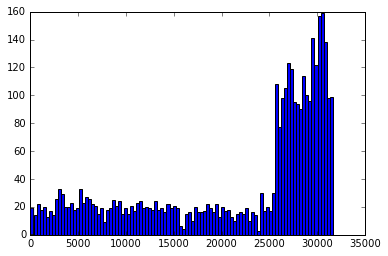

In [16]:
priorbibs = set(df['bib'])
missing_bibs = [bib for bib in df15['bib'] if bib not in priorbibs]
print '# of bib numbers with no priors: ', len(missing_bibs)
plt.hist(missing_bibs, bins=100)
plt.show()

For 2015, non-qualifiers were assigned bib numbers > ~26,000 (aka Charity runners).  It appears a chunk of our runners are indeed first timers.  But we are missing running histories for other runners too.

### Build Dataframe for Modelling

In [17]:
# One row per running record.  We will combine runner predictions later
feature_columns = [u'bib', u'age', u'gender', u'elite', u'qualifier', 
                   u'home', 
                   u'avgtemp', u'avghumid', u'avgwind', u'avgwindE', u'avgwindN', u'isgusty',
                   u'rainhours','prior_year', 'prior_time', 'prior_marathon']
#model_df = pd.get_dummies(unique_df[feature_columns])
model_df = pd.get_dummies(df[feature_columns])
X = model_df.values
y = df['offltime'].values
print X.shape, y.shape

(101850, 996) (101850,)


### Mean as a Model

Train R^2: 0.0
Test R^2: 0.0
Standard Error of Test: 0:36:48


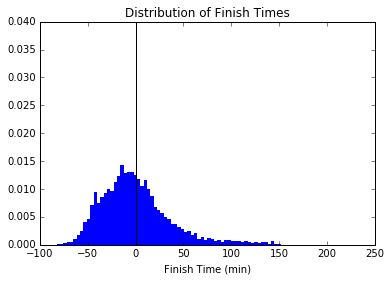

In [18]:
model = DummyRegressor()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

### Regression Model

Train R^2: 0.677361094628
Test R^2: 0.677361094628
Standard Error of Test: 0:20:54


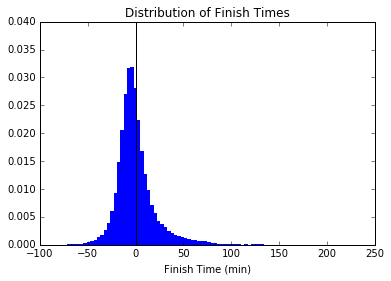

In [19]:
model = LinearRegression()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

Train R^2: 0.657878194496
Test R^2: 0.657878194496
Standard Error of Test: 0:21:31

Lasso Coefficients (alpha= 1 )
------------------
intercept 125.82476962
bib       0.0026356949797
age       0.395676715363
avgtemp   -0.00805552638168
avghumid  -0.00631152618767
avgwindN  0.0163592870784
prior_time0.182476507296


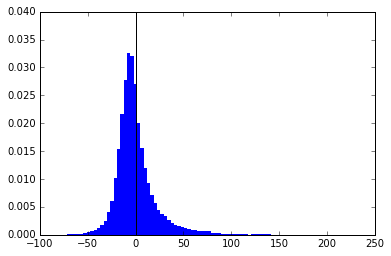

In [20]:
alpha = 1
model = Lasso(alpha=alpha)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
print 
print 'Lasso Coefficients (alpha=',alpha,')'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(model_df.columns, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=732)
print X_train.shape, y_train.shape

(76387, 996) (76387,)


In [22]:
print X_test.shape, y_test.shape

(25463, 996) (25463,)


Train R^2: 0.750333663454
Test R^2: 0.741871084674
Standard Error of Test: 0:18:45


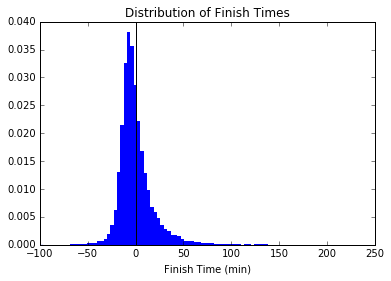

In [23]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

Train R^2: 0.613609459104
Test R^2: 0.589455829811
Standard Error of Test: 0:23:39


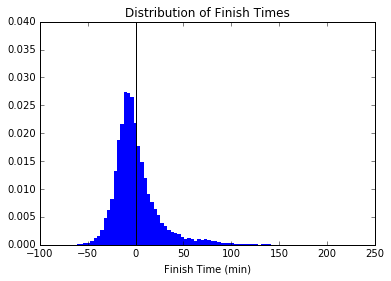

In [24]:
model = RandomForestRegressor(max_depth = 16, max_features = 43, n_estimators = 1000)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-randomforest.png', bbox_inches='tight', dpi=300)
plt.show()

# Pick model

Since we need to train on entire dataset and use the results, we need a model that does not overfit.

### Gradient Boosting Wins

## 1. Tune Gradient Boosting

In [ ]:
# Tune using CV search
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [100],
#                                  'learning_rate': [0.04],
#                                  'max_depth': [4],
#                                  'subsample': [0.7, 0.6, 0.5]},
#                      verbose=True)
# model.fit(X_train, y_train)
# print model.best_params_

In [ ]:
# Bump up the number of estimators and now tune learning_rate
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [500],
#                                  'learning_rate': [0.04, 0.01, 0.003, 0.001],
#                                  'max_depth': [4],
#                                  'subsample': [0.6]},
#                      verbose=True)
# model.fit(X, y)
# print model.best_params_
# plot_model_deviation(model, X, y, X, y)
# plt.title('Distribution of Finish Times')
# plt.xlabel('Finish Time (min)')
# plt.show()

## 2. Fit on entire dataset (- extreme outliers)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1273.7190          73.8094           24.13m
         2        1210.5785          67.2324           23.90m
         3        1147.9123          62.5469           23.78m
         4        1093.0177          58.2312           23.61m
         5        1040.8594          52.7041           23.46m
         6         985.2823          49.0072           23.34m
         7         939.8480          45.2780           23.22m
         8         913.4635          41.3008           23.12m
         9         861.8223          38.5004           23.01m
        10         824.4511          35.7804           22.86m
        20         592.5918          16.1846           21.65m
        30         481.6826           7.6779           20.42m
        40         422.1623           3.7055           19.20m
        50         397.4573           1.9798           17.95m
        60         380.5007           1.1353           16.68m
       

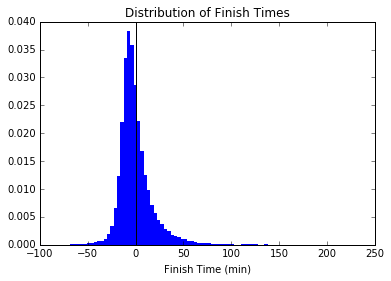

In [25]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

In [26]:
# Remove outliers > 3 std deviations away
y_predict = model.predict(X)
stddev = np.var(y - y_predict)**0.5
outlier = abs(y-y_predict) > 3*stddev

X_clean = model_df[~outlier].values
y_clean = df.loc[~outlier, 'offltime'].values
print X_clean.shape, y_clean.shape

(99946, 996) (99946,)


In [27]:
# Refit model without outliers
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X_clean, y_clean)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1129.0127          72.5611           23.53m
         2        1078.3939          65.5570           23.45m
         3        1011.8809          60.8872           23.32m
         4         947.9393          56.6812           23.14m
         5         889.5767          52.9301           23.05m
         6         842.2985          48.5747           22.91m
         7         795.5025          45.0239           22.79m
         8         762.9435          41.1968           22.69m
         9         725.2982          37.8956           22.56m
        10         679.2166          35.4967           22.42m
        20         450.0982          16.3341           21.21m
        30         340.0895           7.5635           20.00m
        40         284.9529           3.8490           18.80m
        50         257.5081           2.0454           17.59m
        60         241.2188           1.1679           16.37m
       

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.04, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=0.6,
             verbose=True, warm_start=False)

Train R^2: 0.825581229454
Test R^2: 0.825581229454
Standard Error of Test: 0:14:30


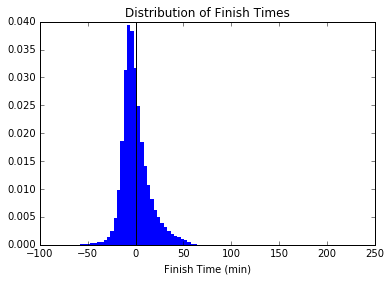

In [28]:
plot_model_deviation(model, X_clean, y_clean, X_clean, y_clean)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

In [29]:
feature_importance = zip(model_df.columns, model.feature_importances_)
sorted(feature_importance, reverse=True, key=lambda x: x[1])[0:20]

[('bib', 0.45989285934261176),
 ('prior_time', 0.13945614424058422),
 ('age', 0.13696075948114744),
 ('prior_year', 0.025462336301343546),
 ('avgtemp', 0.018861016764285896),
 ('home_UT', 0.017472002624479017),
 ('gender', 0.016476816622192195),
 ('prior_marathon_boston', 0.012774345521912707),
 ('prior_marathon_st_george', 0.010569182713453756),
 ('home_AZ', 0.0096961111080617769),
 ('avgwind', 0.0085542924618400313),
 ('home_ID', 0.007519565384392011),
 ('home_MN', 0.0072402259129723066),
 ('home_IN', 0.006034405002807961),
 ('home_AUS', 0.0059080478264555356),
 ('home_GBR', 0.0059010673555163883),
 ('home_CAN', 0.0057987182836129383),
 ('home_MA', 0.0056996664866208017),
 ('avgwindN', 0.0055708993838072037),
 ('home_MI', 0.0054703557059802123)]

## 3. Select outliers.

Train R^2: 0.738834729161
Test R^2: 0.738834729161
Standard Error of Test: 0:18:46


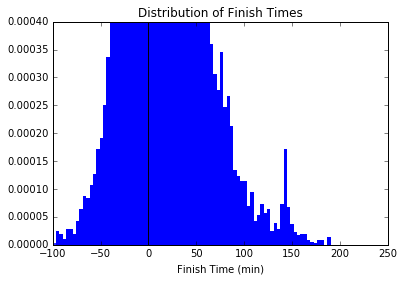

In [30]:
# Plot showing outliers
plot_model_deviation(model, X, y, X, y, y_max = 0.0004)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('outliers-zoom.png', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
y_predict = model.predict(X)

In [32]:
model_df['predicted_time'] = y_predict

In [33]:
cheaters = pd.read_csv('data/boston2015_cheaters.csv')
cheaters = set(cheaters['bib'])
print len(cheaters)

58


In [34]:
stddev = np.var(y - y_predict)**0.5
outliers = (y - y_predict > 1 * stddev)
outlier_bibs = df.loc[outliers, 'bib'].unique()

print 'Standard Error:', stddev
print '# of outlier records:', sum(outliers)
print
print 'Total # of unique runners:', len(df['bib'].unique())
print '# of cheaters in our unique runners:', len([bib for bib in df['bib'].unique() if bib in cheaters])
print 'Cheating rate in our runners: {:.2f}%'.format(len([bib for bib in df['bib'].unique() if bib in cheaters]) * 100. 
                                                     / len(df['bib'].unique()))
print '# of unique outliers:', len(df.loc[outliers, 'bib'].unique())
print '# of cheaters in our outliers:', len([bib for bib in outlier_bibs if bib in cheaters])
print 'Cheating rate in our outliers: {:.2f}%'.format(len([bib for bib in outlier_bibs if bib in cheaters]) * 100. 
                                                      / len(df.loc[outliers, 'bib'].unique()))


Standard Error: 18.7626860699
# of outlier records: 11797

Total # of unique runners: 22724
# of cheaters in our unique runners: 49
Cheating rate in our runners: 0.22%
# of unique outliers: 3187
# of cheaters in our outliers: 44
Cheating rate in our outliers: 1.38%


In [35]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_uniques(df):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        runner['predicted'] = np.mean((runners['predicted']))
        runner['difference'] = runner['offltime'] - runner['predicted']
        runner['median_difference'] = runner['offltime'] - np.median((runners['predicted']))
        runner['min_difference'] = runner['offltime'] - np.min((runners['predicted']))
        runner['max_difference'] = runner['offltime'] - np.max((runners['predicted']))
        if len(runners) > 1:
            # If multiple records exist for a runner, then save the following columns
            runner['2ndmin_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[1]
            runner['2ndmax_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[-2]
        else:
            runner['2ndmin_difference'] = runner['difference']
            runner['2ndmax_difference'] = runner['difference']
        runners_list.append(runner)
    unique_df = pd.DataFrame(runners_list)
    return unique_df

In [36]:
# Make cheater prediction table
# bib, y, y_predict, cheater
predict_df = pd.DataFrame(model_df['bib'])
predict_df['offltime'] = y
predict_df['predicted'] = y_predict
predict_df['difference'] = y - y_predict
predict_df['cheater'] = model_df['bib'].isin(cheaters)
print predict_df.shape
predict_df = get_uniques(predict_df)
print predict_df.shape

(101850, 5)
(22724, 10)


In [37]:
print predict_df['difference'].min(), predict_df['difference'].max()

-95.9994497797 187.376674012


In [38]:
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
print roc_auc_score(predict_df['cheater'], predict_df['difference'])
print roc_auc_score(predict_df['cheater'], predict_df['median_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['min_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['2ndmin_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['max_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['2ndmax_difference'])

0.923552415454
0.922873793398
0.918144139685
0.922965596382
0.926891523975
0.923142902144


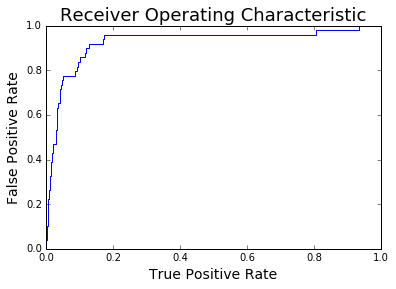

In [40]:
fprs, tprs, thresholds = roc_curve(- predict_df['cheater'], predict_df['max_difference'])
plt.plot(tprs, fprs)
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.xlabel('True Positive Rate', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.savefig('roc_curve.png', bbox_inches='tight', dpi=300)
plt.show()

In [44]:
print 'Overall'
print '{}/{} ({:.2f}%)'.format(sum(predict_df['cheater']), len(predict_df), sum(predict_df['cheater']) * 100. / len(predict_df))
print
out_str = '{:9.1f}  {:5.3f}  {:5.3f}  {:8}  {:7}  {:4.2f}'
print 'threshold   tpr    fpr   cheaters  records  rate'
print '---------  -----  -----  --------  -------  ----'
for i in range(70, 90):
    threshold = thresholds[i]
    flagged = predict_df.loc[predict_df['max_difference'] > threshold, 'cheater']
    print out_str.format(thresholds[i], tprs[i], fprs[i], sum(flagged), len(flagged), sum(flagged) * 100. / len(flagged))

Overall
49/22724 (0.22%)

threshold   tpr    fpr   cheaters  records  rate
---------  -----  -----  --------  -------  ----
     33.3  0.042  0.714        34      995  3.42
     31.9  0.045  0.714        35     1058  3.31
     31.9  0.045  0.735        35     1059  3.31
     30.9  0.048  0.735        36     1127  3.19
     30.9  0.048  0.755        36     1128  3.19
     30.6  0.049  0.755        37     1149  3.22
     30.5  0.049  0.776        37     1150  3.22
     20.8  0.085  0.776        38     1954  1.94
     20.8  0.085  0.796        38     1955  1.94
     19.6  0.091  0.796        39     2110  1.85
     19.6  0.091  0.816        39     2111  1.85
     19.0  0.094  0.816        40     2178  1.84
     19.0  0.094  0.837        40     2179  1.84
     18.0  0.101  0.837        41     2320  1.77
     18.0  0.101  0.857        41     2321  1.77
     15.7  0.115  0.857        42     2643  1.59
     15.7  0.115  0.878        42     2644  1.59
     15.2  0.118  0.878        43     2722 

In [47]:
# Set threshold at 30.0 min
threshold = 30.0
flagged = predict_df.loc[predict_df['max_difference'] > threshold, 'cheater']
out_str = '{:9.1f}  {:8}  {:7}  {:4.2f}'
print 'threshold  cheaters  records  rate'
print '---------  --------  -------  ----'
print out_str.format(threshold, sum(flagged), len(flagged), sum(flagged) * 100. / len(flagged))

threshold  cheaters  records  rate
---------  --------  -------  ----
     30.0        38     1181  3.22


In [42]:
print 8229 in cheaters
runners = predict_df[predict_df['bib'] == 8229]
print runners.T

True
                       172
bib                   8229
offltime             241.7
predicted          205.191
difference         36.5089
cheater               True
median_difference  35.0837
min_difference     41.3318
max_difference     34.5365
2ndmin_difference  35.0863
2ndmax_difference  35.0811


In [43]:
model_df[model_df['bib'] == 8229].T

,172,3253,7184,22148
bib,8229,8229,8229,8229
age,47,47,47,47
gender,True,True,True,True
elite,False,False,False,False
qualifier,False,False,False,False
avgtemp,74.6857,73.5143,54.5571,62.1571
avghumid,43.5714,70.1429,62,54
avgwind,5.94286,16.8,13.0143,9.21429
avgwindE,1.26104,-10.8871,-9.34949,3.741
avgwindN,5.51586,-9.12698,8.45265,6.65185
